Notebook correspondant à la section 4.1.2 du rapport, pour la résolution des équations sur $M_x$ et $M_y$ couplées de la précession amortie :
\begin{equation}
\left\{
    \begin{aligned}
        \frac{dM_x}{d\tilde{t}} &= - M_y\omega_z - \lambda M_x M_z \omega_z \\
        \frac{dM_y}{d\tilde{t}} &= M_x\omega_z - \lambda M_y M_z \omega_z
    \end{aligned}
\right.
\end{equation}

In [2]:
#imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Physical parameters

In [13]:
#initial value for M = [Mx, My] vector
M_0 = tf.constant([1,0], dtype='float32') 
#initial value for Mz
M_z0 = tf.constant(0, dtype='float32') 
W = 2*np.pi
lamb = 0.3

Training parameters

In [24]:
N = 40 #number of samples for the independant variable
t_a = -1
t_b = 1
training_points = np.linspace(t_a,t_b,N)
training_points = tf.convert_to_tensor(training_points, dtype=tf.float32)

load_model = False
load_filename = "models/2_NN_direct_training_N=10"
save_model = False
save_filename = "models/2_NN_direct_training_N=100"


Load the model for the evolution of Mz

In [9]:
Mz_model_filename = "Mz_NN"
Mz_model = tf.keras.models.load_model(Mz_model_filename)
Mz_NN = Mz_model(training_points)

Mz_tensor = M_z0+training_points*Mz_NN[:,0]

Initializing the network

In [10]:
# Network Parameters
n_input = 1     # input layer number of neurons
n_hidden_1 = 16 # 1st layer number of neurons
n_output = 2    # output layer number of neurons

#model definition :
model = tf.keras.Sequential([
  tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.sigmoid, input_shape=(n_input,)),  
  tf.keras.layers.Dense(n_output)
])

if load_model :
    model = tf.keras.models.load_model(load_filename)



Loss function
https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape


In [11]:
def loss_function(model, input_tensor, M_0, lamb, Mz_tensor):

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_tensor)
        output = model(input_tensor)
        Mx, My = M_0[0]+input_tensor*output[:,0], M_0[1]+input_tensor*output[:,1]

    dMx = tape.gradient(Mx, input_tensor)
    dMy = tape.gradient(My, input_tensor)

    ex = dMx + W*(My + lamb*tf.multiply(Mx,Mz_tensor))
    ey = dMy + W*(-Mx + lamb*tf.multiply(My,Mz_tensor))

    return tf.reduce_mean(ex**2 + ey**2)

Gradient of loss

In [12]:
def grad(model, input_tensor, M_0, lamb, Mz_tensor):
    with tf.GradientTape() as tape:
        loss_value = loss_function(model, input_tensor, M_0, lamb, Mz_tensor)

    gradient = tape.gradient(loss_value, model.trainable_variables)

    return loss_value, gradient

Training the neural network

In [40]:
learning_rate = 7e-3
epochs = 5000
display_step = min(max(1,epochs//100), 1000)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

In [41]:
losses = []
epochs_displayed = []

for epoch in range(epochs) :
    loss_value, grads = grad(model, training_points, M_0, lamb, Mz_tensor)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    if epoch % display_step == 0 :
        print("Loss after",epoch,"/",epochs,"epochs :",loss_value.numpy())
        losses.append(loss_value.numpy())
        epochs_displayed.append(epoch)

loss_value, grads = grad(model, training_points, M_0, lamb, Mz_tensor)
print("Final loss after",epochs,"epochs :",loss_value.numpy())
losses.append(loss_value.numpy())
epochs_displayed.append(epochs)

Loss after 0 / 5000 epochs : 0.43898124
Loss after 50 / 5000 epochs : 0.4379891
Loss after 100 / 5000 epochs : 0.43700808
Loss after 150 / 5000 epochs : 0.43603745
Loss after 200 / 5000 epochs : 0.43507615
Loss after 250 / 5000 epochs : 0.43412352
Loss after 300 / 5000 epochs : 0.43318263
Loss after 350 / 5000 epochs : 0.4322486
Loss after 400 / 5000 epochs : 0.4313259
Loss after 450 / 5000 epochs : 0.430411
Loss after 500 / 5000 epochs : 0.42950517
Loss after 550 / 5000 epochs : 0.42860708
Loss after 600 / 5000 epochs : 0.42771825
Loss after 650 / 5000 epochs : 0.4268368
Loss after 700 / 5000 epochs : 0.42596358
Loss after 750 / 5000 epochs : 0.42509955
Loss after 800 / 5000 epochs : 0.42424124
Loss after 850 / 5000 epochs : 0.42339152
Loss after 900 / 5000 epochs : 0.42254877
Loss after 950 / 5000 epochs : 0.4217123
Loss after 1000 / 5000 epochs : 0.4208848
Loss after 1050 / 5000 epochs : 0.42006284
Loss after 1100 / 5000 epochs : 0.41924828
Loss after 1150 / 5000 epochs : 0.4184392


In [18]:
if save_model :
    model.save(save_filename)

Plot the evolution of loss

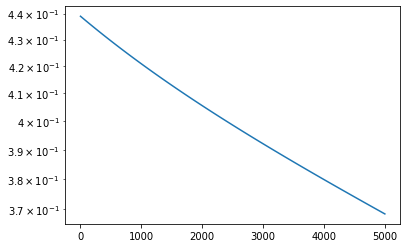

In [42]:
plt.plot(epochs_displayed, losses)
plt.yscale('log')
plt.show()


Compute the analytic solution

In [43]:
plotting_points = np.linspace(t_a,t_b,200)
plotting_points = tf.convert_to_tensor(plotting_points, dtype=tf.float32)
W=-W
#for plotting_points
K = (M_z0-1) / (M_z0+1)
exp_vector = tf.exp(lamb*W*plotting_points)
F = exp_vector*(K-1)/(K*exp_vector**2-1)

Mx_ana =tf.multiply( F,(  tf.cos(W*plotting_points)*M_0[0] + tf.sin(W*plotting_points)*M_0[1]))
My_ana = tf.multiply(F,(- tf.sin(W*plotting_points)*M_0[0] + tf.cos(W*plotting_points)*M_0[1]))

#for training_points
K = (M_z0-1) / (M_z0+1)
exp_vector = tf.exp(lamb*W*training_points)
F = exp_vector*(K-1)/(K*exp_vector**2-1)

Mx_training =tf.multiply( F,(  tf.cos(W*training_points)*M_0[0] + tf.sin(W*training_points)*M_0[1]))
My_training = tf.multiply(F,(- tf.sin(W*training_points)*M_0[0] + tf.cos(W*training_points)*M_0[1]))
W=-W

Plot the estimation and the analytic solution

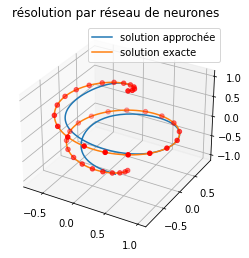

In [44]:
#neural network estimation
output = model(plotting_points)
Mx_NN, My_NN = M_0[0]+plotting_points*output[:,0], M_0[1]+plotting_points*output[:,1]


#3D plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(        xs=Mx_NN,
                ys=My_NN,
                zs=plotting_points,
                label='solution approchée')

ax.plot(        xs=Mx_ana,
                ys=My_ana,
                zs=plotting_points,
                label='solution exacte')



ax.scatter(     xs=Mx_training,
                ys=My_training,
                zs=training_points,
                color='red')

plt.legend()
plt.title('résolution par réseau de neurones')
plt.show()